In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import numpy as np
import xarray as xr
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from src.data.rasters import load_site_formated_raster
from src.root_path import config_path, root_path
from src.utils.subsets import good_sites
from src.metrics.simple_diff import ctx_effects_as_DF

from src.models.decoder import unfold_rep_ctx_prb, get_svm_accuracy, decode_and_plot
from src.data.diagonalization import get_diagonalizations, plot_eg_diag

from src.visualization.interactive import plot_site_coverages, plot_raw_pair_array
from src.visualization.palette import Grey, FOURCOLOR, TENCOLOR

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-03-03 212020.log


cannot connect to database, loading hardcoded sites
cannot connect to database, loading hardcoded cells. TODO!


# purpose
after a first exploration of alternatives for densifying the naturally sparse contextual effects, we have simply
forced the response of all neurons to be equal for any given context (once the probe effect is subtracted),
while at the same time preserving the total response across all neurons.

For example, in a system of 2 neurons, x and y,
their original response to the context i are different: xi != yi and
xi + yi = A, where A is the total activity level.

After the densification, the modified responses are equal and the total
activity is preserved: xi == yi == A/2

xi == yi defines a diagonal, thus we name this specific approach of densification a **diagonalization**


this notebook presents a refactoring and functionalization of the diagoalization procedure, so we can apply it across
all the sites in our dataset


In [3]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
eg_prb = 3
eg_ctx_pair = [0,1]
eg_cellid = 'ARM021b-36-8'
eg_site = eg_cellid.split('-')[0]

# load cache of sigle cell rasters for this example site
if load_site_formated_raster.check_call_in_cache(eg_site, **raster_meta):
    raster, cellids = load_site_formated_raster(eg_site, **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")


####
found and loaded cache for ARM021b


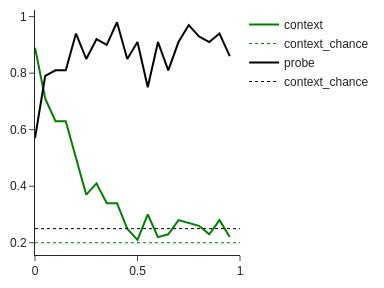

In [4]:
fig, _, _ = decode_and_plot(raster)
fig.show(renderer='jpeg')

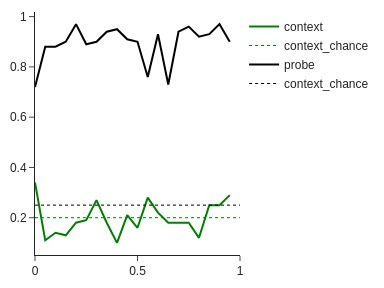

In [5]:
diagonalizer = get_diagonalizations(raster)

fig, _, _ = decode_and_plot(raster + diagonalizer)
fig.show(renderer='jpeg')

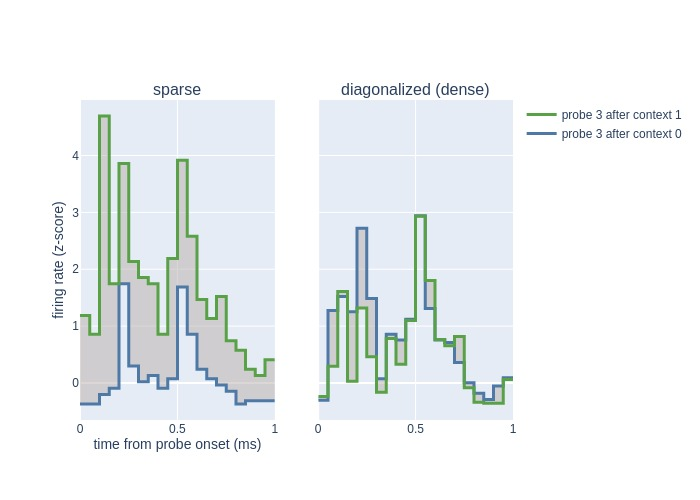

In [6]:
fig = make_subplots(1,2, shared_xaxes='all', shared_yaxes='all', subplot_titles=['sparse', 'diagonalized (dense)'])

traces = plot_raw_pair_array(raster, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=False)['data']
fig.add_traces(traces, rows=[1]*len(traces), cols=[1]*len(traces))

traces = plot_raw_pair_array(raster+diagonalizer, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=True)['data']
fig.add_traces(traces, rows=[1]*len(traces), cols=[2]*len(traces))

_ = fig.update_xaxes(title_text='time from probe onset (ms)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='firing rate (z-score)', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

In [7]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'230220_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists():
    print('cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    accuracy_df = list()
    for site in good_sites:
        fn = load_site_formated_raster
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")


        diagonalizer = get_diagonalizations(raster)
        codes = dict(sparse=raster, dense=raster+diagonalizer)

        for code, rast in codes.items():

            unfolded, labels = unfold_rep_ctx_prb(rast)
            for part in ['context', 'probe']:
                accuracy, chance = get_svm_accuracy(unfolded, labels[part])

                d = {'site': site,
                     'code': code,
                     'part': part,
                     'accuracy': accuracy,
                     'chance': chance}

                accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)

    jl.dump(accuracy_df, acc_df_file)

cache found, reloading
